# Does the decay rate of debris in orbit correlate to solar flux?

In [ ]:
# set up expected input files from NOOA flux density
!wget -r -np -R "index.html*" http://themartianlife.com/uploads/solar/ -P /content/

In [ ]:
import glob, os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

stage1_input = "/content/satcat.csv"
stage1_output = "/content/debris-objects.csv"
stage2_output = "/content/tles.csv"

CYCLE_BOUNDS = [
    datetime(year=2019, month=12, day=1),   # December 2019
    datetime(year=2008, month=1, day=1),    # January 2008
    datetime(year=1996, month=5, day=1),    # May 1996
    datetime(year=1986, month=9, day=1),    # September 1986
    # datetime(year=1976, month=3, day=1),    # March 1976
    # datetime(year=1964, month=10, day=1),   # October 1965
]

## Stage 1: Identify Target Objects

* Objects currently in LEO around Earth (perigee < 1000km)
* That were launched over 3 solar cycles ago (pre-1986)
* That are large objects (known RCS)
* That were always debris (rocket bodies)

In [ ]:
df = pd.read_csv(stage1_input)

# adjust column value types
df["LAUNCH_DATE"] = pd.to_datetime(df.LAUNCH_DATE, errors="ignore")
df["DECAY_DATE"] = pd.to_datetime(df.DECAY_DATE, errors="ignore")

df.head()

,OBJECT_NAME,OBJECT_ID,NORAD_CAT_ID,OBJECT_TYPE,OPS_STATUS_CODE,OWNER,LAUNCH_DATE,LAUNCH_SITE,DECAY_DATE,PERIOD,INCLINATION,APOGEE,PERIGEE,RCS,DATA_STATUS_CODE,ORBIT_CENTER,ORBIT_TYPE
0,SL-1 R/B,1957-001A,1,R/B,D,CIS,1957-10-04,TYMSC,1957-12-01,96.19,65.10,938.0,214.0,20.420,NaN,EA,IMP
1,SPUTNIK 1,1957-001B,2,PAY,D,CIS,1957-10-04,TYMSC,1958-01-03,96.10,65.00,1080.0,64.0,NaN,NaN,EA,IMP
2,SPUTNIK 2,1957-002A,3,PAY,D,CIS,1957-11-03,TYMSC,1958-04-14,103.74,65.33,1659.0,211.0,0.080,NaN,EA,IMP
3,EXPLORER 1,1958-001A,4,PAY,D,US,1958-02-01,AFETR,1970-03-31,88.48,33.15,215.0,183.0,NaN,NaN,EA,IMP
4,VANGUARD 1,1958-002B,5,PAY,NaN,US,1958-03-17,AFETR,NaT,132.72,34.25,3833.0,649.0,0.122,NaN,EA,ORB


In [ ]:
def leap_years_since(year):
    total = 0
    for y in range(year, 2022):
        if y % 4 == 0: total += 1
    return total

def timedelta_(years):
    extra_days = leap_years_since(2022 - years)
    return timedelta(days=(365 * years) + extra_days)

In [ ]:
total_count = len(df)
print(f"Total objects:\t\t\t{total_count} objects")

# still in orbit
now = datetime.now()
df = df[(df.DECAY_DATE.isna()) | (df.DECAY_DATE > now)]
print(f"& Still in orbit:\t\t{len(df)} objects")

# launched three solar cycles ago
three_cycles_ago = now - timedelta_(years=36)
df = df[df.LAUNCH_DATE < three_cycles_ago]
print(f"& Launched over a year ago:\t{len(df)} objects")

# non-manoeuvrable (debris objects)
operational = ["+", "P", "B", "S", "X"]
df = df[~df.OPS_STATUS_CODE.isin(operational)]
print(f"& Inactive:\t\t\t{len(df)} objects")

# began as debris
debris = ["R/B"]
df = df[df.OBJECT_TYPE.isin(debris)]
print(f"& Began as debris:\t\t{len(df)} objects")

# orbiting around Earth
df = df[df.ORBIT_CENTER == "EA"]
df = df[df.ORBIT_TYPE == "ORB"]
print(f"& Orbiting Earth:\t\t{len(df)} objects")

# with a known RCS
df = df[~df.RCS.isna()]
print(f"& Known RCS:\t\t\t{len(df)} objects")

# objects in Low Earth Orbit will be hit worst
df = df[df.PERIGEE < 1000.0]
print(f"& In LEO:\t\t\t{len(df)} objects")

new_count = len(df)
print(f"= {round((new_count / total_count) * 100, 2)}% of catalogue")

Total objects:			52934 objects
& Still in orbit:		25620 objects
& Launched over a year ago:	7058 objects
& Inactive:			7039 objects
& Began as debris:		798 objects
& Orbiting Earth:		749 objects
& Known RCS:			692 objects
& In LEO:			438 objects
= 0.83% of catalogue


In [ ]:
# reset row numbering
df = df.reset_index()
# and make df nice again by removing columns that now have single or unimportant values
df = df.drop(["index", "OBJECT_TYPE", "OPS_STATUS_CODE", "OWNER", "DECAY_DATE", "LAUNCH_SITE", "DATA_STATUS_CODE", "ORBIT_CENTER", "ORBIT_TYPE"], axis=1)
df.head()

,OBJECT_NAME,OBJECT_ID,NORAD_CAT_ID,LAUNCH_DATE,PERIOD,INCLINATION,APOGEE,PERIGEE,RCS
0,VANGUARD R/B,1959-001B,12,1959-02-17,125.80,32.90,3323.0,554.0,0.5266
1,VANGUARD R/B,1958-002A,16,1958-03-17,137.30,34.26,4224.0,652.0,0.2282
2,THOR ABLESTAR R/B,1960-007C,47,1960-06-22,99.84,66.67,907.0,594.0,2.9661
3,THOR ABLESTAR R/B,1960-013B,59,1960-10-04,106.43,28.25,1202.0,921.0,3.4517
4,SCOUT X-1 R/B,1961-004B,82,1961-02-16,117.45,38.85,2497.0,636.0,0.5330


In [ ]:
def get_all_tles_for_id(norad_id):
    url = "https://www.space-track.org/basicspacedata/query/" \
        f"class/gp_history/NORAD_CAT_ID/{norad_id}/orderby/EPOCH desc/format/csv"


In [ ]:
df.to_csv(stage1_output)

## Stage 2: Isolate Detections

* run TLE-to-CSV conversion
* combine data logs from each year (1986 - now)
* calculate mean altitude from TLE data, or estimate from mean motion? 

In [ ]:
dataframes = []
total_records = 0

for i, filepath in enumerate(glob.glob("/content/tle*.csv")):
    df = pd.read_csv(filepath)
    records = len(df)
    print(f"File {i}: {filepath} ({records} lines)")
    dataframes.append(df)
    total_records += records

File 0: /content/tle2012.csv (102724 lines)
File 1: /content/tle2016.csv (115055 lines)
File 2: /content/tle2011.csv (112710 lines)
File 3: /content/tle2008.csv (101689 lines)
File 4: /content/tle2020.csv (157506 lines)
File 5: /content/tle2004_8of8.csv (39118 lines)
File 6: /content/tle2004_5of8.csv (21389 lines)
File 7: /content/tle2021.csv (177000 lines)
File 8: /content/tle2007.csv (108469 lines)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


File 9: /content/tle2005.csv (515981 lines)
File 10: /content/tle2004_3of8.csv (74612 lines)
File 11: /content/tle2004_1of8.csv (52645 lines)
File 12: /content/tle2015.csv (75496 lines)
File 13: /content/tle2004_6of8.csv (167334 lines)
File 14: /content/tle2019.csv (115079 lines)
File 15: /content/tle2004_7of8.csv (669307 lines)
File 16: /content/tle2004_4of8.csv (29662 lines)
File 17: /content/tle2009.csv (115636 lines)
File 18: /content/tle2013.csv (51669 lines)
File 19: /content/tle2006.csv (112731 lines)
File 20: /content/tle2017.csv (133403 lines)
File 21: /content/tle2018.csv (142975 lines)
File 22: /content/tle2004_2of8.csv (75307 lines)
File 23: /content/tle2010.csv (107753 lines)
File 24: /content/tle2014.csv (51132 lines)


In [ ]:
df = pd.concat(dataframes, ignore_index=True)
df = df[df.TIMESTAMP >= CYCLE_BOUNDS[-1]]
print(f"All records present ({len(df)} records): {len(df) == total_records}")
df.to_csv(stage2_output)

All records present (3426382 records): True


In [ ]:
df = df.sort_values(by=["NORAD_CAT_ID", "TIMESTAMP"])
df["TIMESTAMP"] = pd.to_datetime(df.TIMESTAMP)

In [ ]:
def plot_object(norad_cat_id):
    fig, axs = plt.subplots()
    df[df.NORAD_CAT_ID == norad_cat_id].plot(x="TIMESTAMP", y="MEAN_MOTION", ax=axs)
    t = [df.TIMESTAMP.min(), df.TIMESTAMP.max()]
    fig.suptitle(f"Object #{norad_cat_id}")
    axs.set_xticks(t)
    axs.set_xticklabels(["June 1959", "December 2021"], rotation=0, ha="center")
    axs.get_legend().remove()
    axs.set_ylabel("Orbits per day")
    axs.set_xlabel("Time")
    plt.gca().invert_yaxis()
    for bound in CYCLE_BOUNDS:
        axs.axvline(x=bound, color='r')
    fig.show()

In [ ]:
ids = [12,16,47,59,82,118,204,341,426,575,721,727,733,809,815,871,877,907,933,979,
	1245,1358,1433,1583,1616,1739,1805,1807,1815,1863,1865,1953,1983,
	2017,2120,2123,2124,2144,2180,2206,2328,2422,2621,2622,2643,2671,2682,2741,2802,2825,2940,2971,2985,
	3048,3177,3212,3230,3271,3315,3341,3522,3598,3670,3827,
	4048,4071,4139,4159,4251,4298,4332,4354,4370,4377,4394,4420,4513,4515,4579,4589,4597,4784,4800,4814,4882,4903,4954,
	5051,5118,5126,5175,5239,5395,5438,5498,5556,5581,5685,5707,5730,5732,5816,5847,5904,5918,5977,
	6020,6058,6061,6080,6127,6149,6155,6180,6207,6218,6237,6257,6276,6324,6393,6660,6708,6779,6788,6797,6829,6910,6966,
	7009,7095,7210,7219,7228,7275,7350,7364,7412,7434,7477,7493,7545,7575,7594,7616,7647,7715,7735,7737,7769,7800,7902,
	8018,8027,8073,8134,8294,8331,8344,8352,8421,8459,8520,8546,8597,8621,8646,8710,8800,8840,8846,8861,8874,8924,
	9013,9023,9044,9062,9329,9330,9444,9482,9510,9613,9638,9662,9738,9786,9848,9904,
	10011,10020,10025,10062,10096,10114,10121,10138,10142,10144,10155,10295,10355,10461,10485,10490,10513,10515,10517,10521,10537,10541,10600,10675,10677,10693,10704,10722,10723,10732,10745,10777,10779,10793,10894,10918,10949,10954,10962,10974,10976,10992,10998,
	11028,11112,11166,11239,11267,11289,11309,11321,11327,11379,11427,11511,11574,11586,11608,11636,11668,11672,11681,11736,11751,11792,11804,11822,11870,11963,11984,
	12088,12092,12139,12150,12155,12159,12298,12363,12443,12445,12457,12465,12497,12508,12586,12646,12679,12682,12786,12787,12792,12804,12827,12836,12849,12889,12904,12988,
	13007,13016,13028,13034,13066,13068,13075,13111,13114,13121,13128,13149,13154,13242,13260,13272,13302,13354,13403,13493,13553,13608,13609,13618,13649,13658,13666,13719,13758,13771,13778,13819,13882,13897,13917,13950,13971,13992,
	14033,14051,14059,14085,14096,14135,14136,14148,14155,14208,14241,14277,14278,14373,14402,14451,14453,14524,14547,14552,14607,14608,14625,14680,14700,14760,14820,14900,14966,14974,
	15032,15053,15054,15056,15078,15100,15202,15206,15223,15244,15245,15246,15265,15266,15293,15332,15334,15335,15338,15360,15370,15387,15388,15390,15392,15399,15402,15483,15495,15506,15517,15562,15593,15596,15598,15644,15714,15715,15752,15772,15773,15774,15832,15836,15837,15874,15876,15890,15938,15945,15996,
	16001,16007,16012,16182,16229,16263,16292,16293,16294,16295,16327,16369,16409,16445,16446,16483,16494,16496,16511,16528,16612,16615,16657,16682,16720,16728,16736,16792,16799,16864,16882]

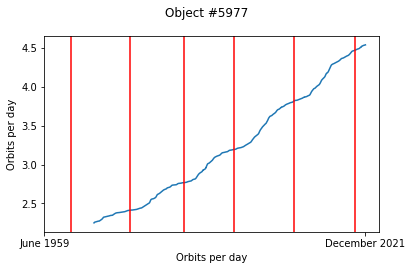

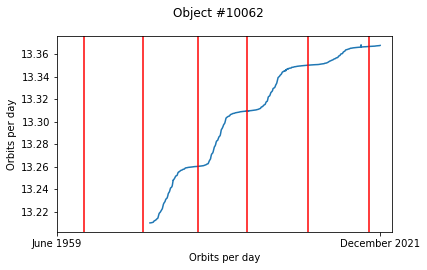

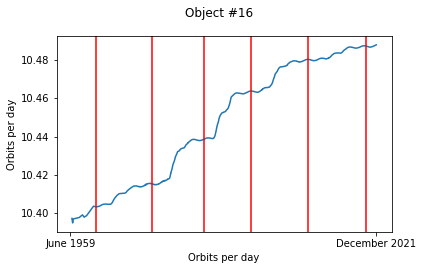

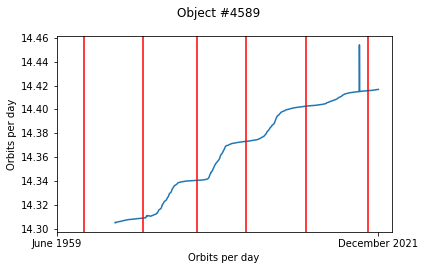

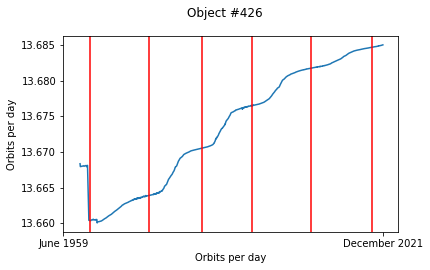

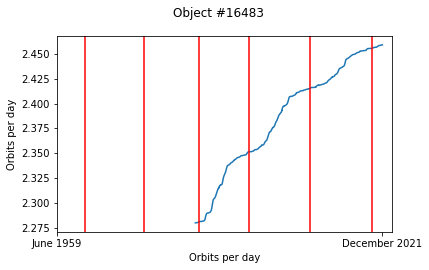

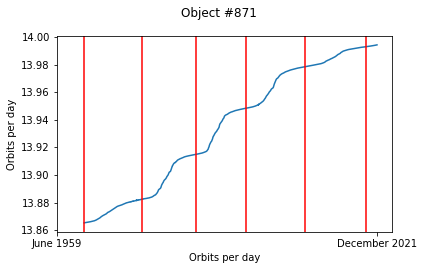

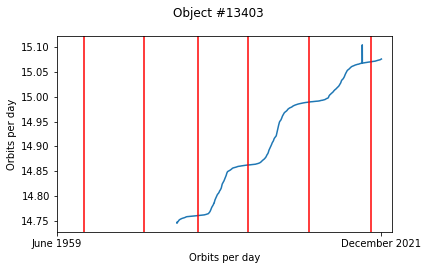

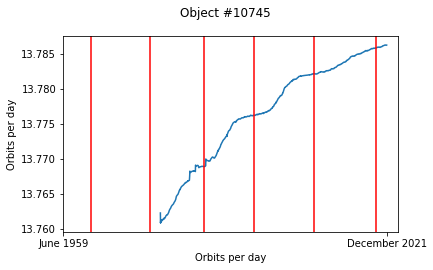

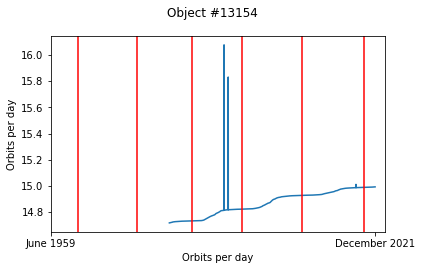

In [ ]:
# let's have a quick look at correlation with mean motion alone
# on a random sample of objects
import random
for i in range(10):
    id = random.choice(ids)
    plot_object(id)

In [ ]:
solar = pd.read_csv("/content/composite_d25_07_0310a.dat", header=None, names=["DATE", "EPOCH_DATE", "ACTIVITY"], delim_whitespace=True)

def map_date(date_seq):
    date_string = str(date_seq).zfill(6)
    year = int(date_string[0:2])
    year += (1900 if year > 30 else 2000)
    month = int(date_string[2:4])
    day = int(date_string[4:6])
    return datetime(year=year, month=month, day=day)

def map_level(level):
    if int(level) == -99: return None
    return level

In [ ]:
solar["TIMESTAMP"] = solar.DATE.apply(map_date)
solar["LEVEL"] = solar.ACTIVITY.apply(map_level)
solar.head()

,DATE,EPOCH_DATE,ACTIVITY,TIMESTAMP,LEVEL
0,781116,-409.5,-99.0000,1978-11-16,NaN
1,781117,-408.5,1365.3416,1978-11-17,1365.3416
2,781118,-407.5,1365.2366,1978-11-18,1365.2366
3,781119,-406.5,-99.0000,1978-11-19,NaN
4,781120,-405.5,1365.9519,1978-11-20,1365.9519


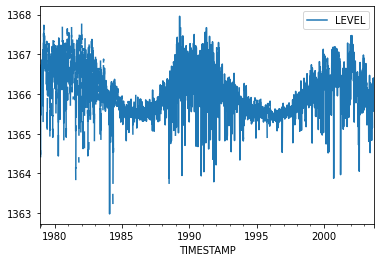

In [ ]:
solar.plot(x="TIMESTAMP", y="LEVEL")